<a href="https://colab.research.google.com/github/coriander4all/benchmark_cassandra-postgres/blob/main/TDLE_Dorian_Loup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Presentation




This benchmark compares Cassandra and Postgresql in terms of CRUD operation time. The data used in this benchmark is taken from randomuser.me which provides randomly generated information about people.

## About the database management systems (DBMS)

### Cassandra
Cassandra follows a wide-column data-base, meaning that the columns can vary over the different rows of a table.

Cassandra privilegies accessibility and scalability over consistence.
In fact, in 2012, Rabl et al. [1] show it is the best database in terms of scalability over the number of nodes: it is linear (see graphic below).

Cassandra claims the following advantages:
- A global availability at low latency
- Ease of scaling: in terms of hardware and because of the linarity with respect to the number of nodes
- Flexible schema
- No single point of failure

However, there are some inconvenients:
- No Join and nested queries.
- Non exhaustive data aggregation operations
- Each select requires a partition key to be fast (one can technically search across multiple partitions).



This DBMS will be compared with PostgreSQL, a popular relational database.







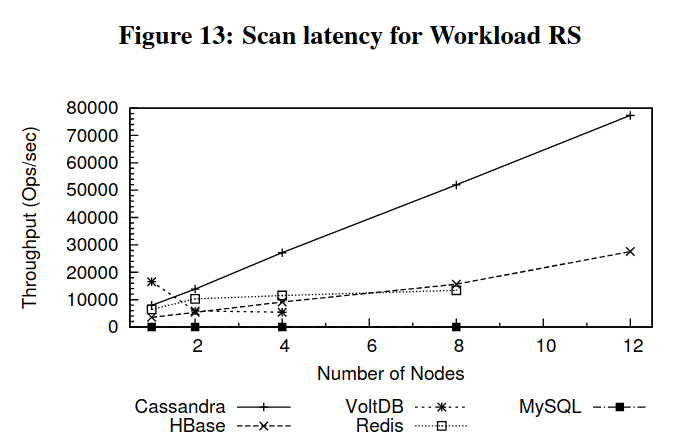

---
# Downloads


## Installing DBMS

In [1]:
#Installing cassandra
!sudo apt update
!sudo apt install -y openjdk-11-jdk
!curl -OL https://dlcdn.apache.org/cassandra/5.0.2/apache-cassandra-5.0.2-bin.tar.gz
!tar xzvf apache-cassandra-5.0.2-bin.tar.gz
!pip install cassandra-driver #Python interface

#Installing dsbulk to load data into cassandra
#!curl -OL https://github.com/datastax/dsbulk/releases/download/1.11.0/dsbulk-1.11.0.tar.gz
#!tar xzvf dsbulk-1.11.0.tar.gz

#Installing Postgresql
!apt-get install -y postgresql postgresql-contrib
!pip install psycopg2 psycopg2-binary

#A bit of cleanup
!rm dsbulk-1.11.0.tar.gz
!rm apache-cassandra-5.0.2-bin.tar.gz

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [60.9 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted

## Getting data for the benchmark

In [2]:
#On télécharge des données aléatoires
#!wget -O data.csv "https://randomuser.me/api/?results=1000&format=csv&inc=name,gender,nat,email&nat=fr&noinfo"

In [65]:
import subprocess

num_data = 500
url = f"https://randomuser.me/api/?results={num_data}&format=csv&inc=name,gender,nat,email&nat=fr&noinfo"
command = f'wget -O data.csv "{url}"'
subprocess.run(command, shell=True)

CompletedProcess(args='wget -O data.csv "https://randomuser.me/api/?results=500&format=csv&inc=name,gender,nat,email&nat=fr&noinfo"', returncode=0)

---
# Processing

## Launching DBMS

In [4]:
#Lauching cassandra
#-R specifies root user (we are forced to since this is colab)
!apache-cassandra-5.0.2/bin/cassandra -R
#Checking cassandra was launched correctly
#!tail -f apache-cassandra-5.0.2/logs/system.log #runs infinitely?
!apache-cassandra-5.0.2//bin/nodetool status

CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.deserializeLargeSubset(Lorg/apache/cassandra/io/util/DataInputPlus;Lorg/apache/cassandra/db/Columns;I)Lorg/apache/cassandra/db/Columns;
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.serializeLargeSubset(Ljava/util/Collection;ILorg/apache/cassandra/db/Columns;ILorg/apache/cassandra/io/util/DataOutputPlus;)V
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.serializeLargeSubsetSize(Ljava/util/Collection;ILorg/apache/cassandra/db/Columns;I)I
CompileCommand: dontinline org/apache/cassandra/db/commitlog/AbstractCommitLogSegmentManager.advanceAllocatingFrom(Lorg/apache/cassandra/db/commitlog/CommitLogSegment;)V
CompileCommand: dontinline org/apache/cassandra/db/transform/BaseIterator.tryGetMoreContents()Z
CompileCommand: dontinline org/apache/cassandra/db/transform/StoppingTransformation.stop()V
CompileCommand: dontinline org/apache/cassandra/db/transform/StoppingTransformation.s

In [5]:
#Launching postgres
!service postgresql stop
!service postgresql start
!sudo -u postgres psql -U postgres -c "CREATE ROLE root WITH SUPERUSER LOGIN PASSWORD 'password';"
!sudo -u postgres psql -c "CREATE DATABASE benchmarkpg OWNER root;"


 * Stopping PostgreSQL 14 database server
   ...done.
 * Starting PostgreSQL 14 database server
   ...done.
CREATE ROLE
CREATE DATABASE


## Initializing databases


In [6]:
from cassandra.cluster import Cluster

cluster = Cluster() #Local cluster (127.0.0.1 implied)
session = cluster.connect()
session.execute("""
  CREATE KEYSPACE IF NOT EXISTS benchmark
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor' : 1};
  """)
session.set_keyspace('benchmark')

session.execute("""
    CREATE TABLE IF NOT EXISTS mytable (
    id UUID PRIMARY KEY,
    gender TEXT,
    name_title TEXT,
    name_first TEXT,
    name_last TEXT,
    email TEXT,
    nat TEXT,
);
""")

In [7]:
import psycopg2
import json

conn = psycopg2.connect(
    dbname="benchmarkpg",
    user="root",
    password="password",
    host="localhost",
    port="5432"
)

# Create a cursor object
cursor = conn.cursor()

# Create a table for the JSON data
cursor.execute("""
CREATE TABLE IF NOT EXISTS mytable (
    id SERIAL PRIMARY KEY,
    gender TEXT,
    name_title TEXT,
    name_first TEXT,
    name_last TEXT,
    email TEXT,
    nat TEXT
);
""")
conn.commit()

## Utilities
- Wrapper to measure execution times

In [36]:
import time
import numpy as np

def uncertainty(values):
  mean = np.mean(values)
  std_dev = np.std(values, ddof=1)
  sem = std_dev / np.sqrt(len(values))
  return mean,sem

#values = [10.5, 13.1, 12.1, 16.5]
#uncertainty(values)

def timer(func):
  def wrapper(*args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    duration = time.time() - start
    print(f"~{func.__name__}\t- Time: {duration}")
    return result
  return wrapper

#iterates a function many times, outputting the mean and the uncertainty
def many_timer(func, iters):
  def wrapper(*args, **kwargs):
    times = []
    for i in range(iters):
      start = time.time()
      result = func(*args, **kwargs)
      duration = time.time() - start
      #print(duration)
      times.append(duration)
    mean_time,sem_time=uncertainty(times)
    print(f"~{func.__name__}\t- Time: {mean_time:.5f}±{sem_time:.5}")
    return result, mean_time, sem_time, times
  return wrapper

  #many_timer(func, 10)(1)

#Measures the time taken only by func, in cases where you need a select to test the function
def many_timer_wrapped(writer, selecter, func, iters):
  times = []
  for i in range(iters):
    writer()
    rows=selecter()

    start = time.time()
    result = func(rows)
    duration = time.time() - start

    times.append(duration)
  mean_time,sem_time=uncertainty(times)
  print(f"~{func.__name__}\t- Time: {mean_time:.5f}±{sem_time:.5}")
  return mean_time, sem_time, times

In [9]:
#distribution of times taken for a select all statement
import pandas as pd
import plotly.graph_objects as go

def plot_distrib_time(c_times, pg_times, title, bin_size=0.03):
  df_c = pd.DataFrame(c_times, columns=["time"])
  df_pg = pd.DataFrame(pg_times, columns=["time"])


  #Distribution of values
  bin_start = min(min(df_c["time"]), min(df_pg["time"]))
  bin_end = max(max(df_c["time"]), max(df_pg["time"]))

  fig = go.Figure()
  fig.add_trace(go.Histogram(
      x=df_c["time"],
      name="Cassandra times",
      xbins=dict(start=bin_start, end=bin_end, size=bin_size)
  ))
  fig.add_trace(go.Histogram(
      x=df_pg["time"],
      name="Postgres times",
      xbins=dict(start=bin_start, end=bin_end, size=bin_size)
  ))

  fig.update_layout(
      barmode='overlay',
      title=title,
      xaxis_title="Time",
      yaxis_title="Frequency",
      legend_title="Database",
  )

  fig.update_traces(opacity=0.6)
  fig.show()



## Loading the data

In [10]:
#pandas is not very smart with lots of data
import pandas as pd

df=pd.read_csv('data.csv')
df.head()

,gender,name.title,name.first,name.last,email,nat
0,male,Mr,Aurélien,Boyer,aurelien.boyer@example.com,FR
1,male,Mr,Liam,Denis,liam.denis@example.com,FR
2,male,Mr,Yanis,Renard,yanis.renard@example.com,FR
3,female,Miss,Océane,Lemoine,oceane.lemoine@example.com,FR
4,female,Mrs,Lucie,Fleury,lucie.fleury@example.com,FR


### Defining functions for querries

In [11]:
#INSERT
import csv
import uuid

def iter_data():
  with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      pass

def cassandra_write_data():
  session.execute("TRUNCATE mytable")

  with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      row_tuple=tuple(row)
      id=uuid.uuid4()
      #print((id,)+row_tuple)
      #print(type(id))
      session.execute("""
        INSERT INTO mytable
          (id,gender,name_title,name_first,name_last,email,nat)
          VALUES (%s,%s,%s,%s,%s,%s,%s)
        """,
        (id,)+row_tuple
      )

def postgres_write_data():
  cursor.execute("TRUNCATE mytable RESTART IDENTITY CASCADE;")

  with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      row_tuple=tuple(row)
      cursor.execute("""
        INSERT INTO mytable (gender,name_title,name_first,name_last,email,nat)
        VALUES (%s, %s, %s, %s, %s, %s)
      """, row_tuple)
      conn.commit()

In [42]:
#SELECT
def cassandra_select_all():
  rows = session.execute("SELECT * FROM mytable")
  return rows

def postgres_select_all():
  cursor.execute("SELECT * FROM mytable")
  rows = cursor.fetchall()
  return rows

In [31]:
#UPDDATE
def cassandra_fetch_rows_to_update():
  rows = session.execute("SELECT id, name_first, name_last FROM mytable")
  return rows

def cassandra_update_data(rows):

    for row in rows:
        session.execute("""
            UPDATE mytable
            SET name_first = %s, name_last = %s
            WHERE id = %s
        """, (row.name_last, row.name_first, row.id))


def postgres_fetch_rows_to_update():
  cursor.execute("SELECT id, name_first, name_last FROM mytable")
  rows = cursor.fetchall()
  return rows

def postgres_update_data(rows):
    for row in rows:
        cursor.execute("""
            UPDATE mytable
            SET name_first = %s, name_last = %s
            WHERE id = %s
        """, (row[2], row[1], row[0]))

    conn.commit()


In [14]:
#REMOVE
#The rows are extracted outside of the function measured by timer
def cassandra_remove_all_rows(rows):
    for row in rows:
        session.execute("""
            DELETE FROM mytable
            WHERE id = %s
        """, (row.id,))

def postgres_remove_all_rows(rows):
    for row in rows:
        cursor.execute("""
            DELETE FROM mytable
            WHERE id = %s
        """, (row[0],))
        conn.commit()


## Testing times

### Write times

In [66]:
timer(iter_data)()
timer(cassandra_write_data)()
timer(postgres_write_data)()

~iter_data	- Time: 0.0022068023681640625
~cassandra_write_data	- Time: 1.0117008686065674
~postgres_write_data	- Time: 1.4380078315734863


In [16]:
num_iters=5 #Takes a looong time so we'll only calculate incertitude with 5.
#With 5 it should take around 15 seconds:

_,c_mean,c_std,c_times=many_timer(cassandra_write_data, num_iters)()
_,pg_mean,pg_std,pg_times=many_timer(postgres_write_data, num_iters)()

~cassandra_write_data	- Time: 2.78995±0.16561
~postgres_write_data	- Time: 3.16486±0.099815


Here is the distribution over 100 tests

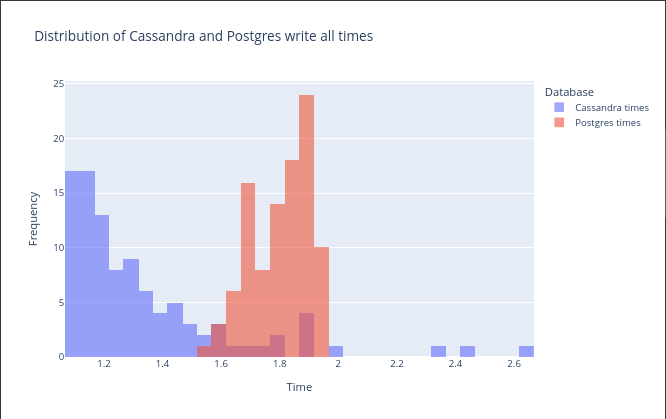

In [17]:
plot_distrib_time(
    c_times,
    pg_times,
    "Distribution of Cassandra and Postgres write all times",
    bin_size=0.05
    )

### Select times

In [101]:
_=timer(cassandra_select_all)()
_=timer(postgres_select_all)()

~cassandra_select_all	- Time: 0.023242473602294922
~postgres_select_all	- Time: 0.0023822784423828125


In [102]:
#num_iters=10
num_iters=100

_,c_mean,c_std,c_times=many_timer(cassandra_select_all, num_iters)()
_,pg_mean,pg_std,pg_times=many_timer(postgres_select_all, num_iters)()

~cassandra_select_all	- Time: 0.01818±0.00058393
~postgres_select_all	- Time: 0.00168±8.6149e-05


In [103]:
plot_distrib_time(
    c_times,
    pg_times,
    "Distribution of Cassandra and Postgres select all times",
    bin_size=0.003
    )

We should notice that one of the queries is much longer than the others

In [105]:
data = pd.DataFrame({
    "Database": ["Cassandra", "Postgres"],
    "Mean Time": [c_mean, pg_mean],
    "Std Dev": [c_std, pg_std]
})

fig = go.Figure(data=[
    go.Bar(
        x=data["Database"],
        y=data["Mean Time"],
        error_y=dict(
            type='data',
            array=data["Std Dev"],
            visible=True
        ),
        name="Mean Times"
    )
])

fig.update_layout(
    title="Average time for a select all query",
    xaxis_title="Database",
    yaxis_title="Time",
    showlegend=False
)

fig.show()


Les select de Cassandra prennent significativement plus de temps.

### Remove times

In [22]:
#Make sure the data is there (write resets the db)
cassandra_write_data()
postgres_write_data()

#Selesct rows separately
c_rows=cassandra_select_all()
pg_rows=postgres_select_all()

_=timer(cassandra_remove_all_rows)(c_rows)
_=timer(postgres_remove_all_rows)(pg_rows)

~cassandra_remove_all_rows	- Time: 1.6684792041778564
~postgres_remove_all_rows	- Time: 2.8055381774902344


In [37]:
num_iters=10

c_mean,c_std,c_times = many_timer_wrapped(
    cassandra_write_data,
    cassandra_select_all,
    cassandra_remove_all_rows,
    num_iters
    )

pg_mean,pg_std,pg_times =many_timer_wrapped(
    postgres_write_data,
    postgres_select_all,
    postgres_remove_all_rows,
    num_iters
    )


~cassandra_remove_all_rows	- Time: 2.00655±0.21423
~postgres_remove_all_rows	- Time: 3.90342±0.15634


In [26]:
plot_distrib_time(
    c_times,
    pg_times,
    "Distribution of Cassandra and Postgres remove all times",
    bin_size=0.03
    )

### Updated times


Bellow is the distribution over 100 iterations

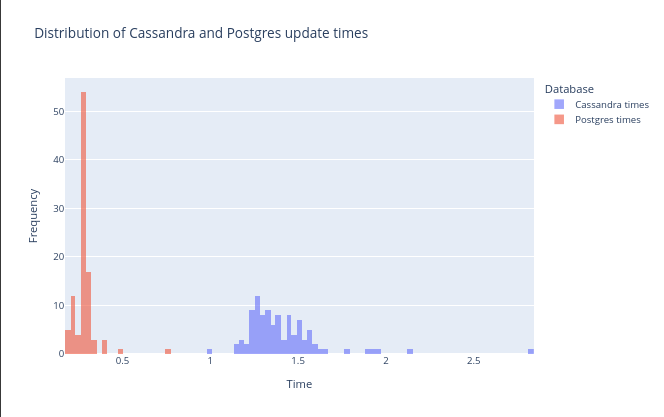

In [40]:
num_iters=5
#num_iters=100

c_mean,c_std,c_times = many_timer_wrapped(
    cassandra_write_data,
    cassandra_fetch_rows_to_update,
    cassandra_update_data,
    num_iters
    )

pg_mean,pg_std,pg_times =many_timer_wrapped(
    postgres_write_data,
    postgres_fetch_rows_to_update,
    postgres_update_data,
    num_iters
    )


~cassandra_update_data	- Time: 1.40833±0.022781
~postgres_update_data	- Time: 0.28417±0.0065649


In [41]:
plot_distrib_time(
    c_times,
    pg_times,
    "Distribution of Cassandra and Postgres update times",
    bin_size=0.03
    )

## Testing with and without index

In [67]:
from cassandra.query import SimpleStatement
from cassandra import ConsistencyLevel

#A select on something other than a primary key
def cassandra_non_primary_select():
  #rows = session.execute("SELECT * FROM mytable WHERE gender = 'F' ALLOW FILTERING")
  query = "SELECT * FROM mytable WHERE gender = 'F' ALLOW FILTERING"
  statement = SimpleStatement(query, consistency_level=ConsistencyLevel.ONE)
  rows = session.execute(statement)
  return rows

In [96]:
num_iters=1000

#Drop the index (when rerunning cell)
session.execute("DROP INDEX IF EXISTS gender_index")
_,c_mean,c_std,c_times=many_timer(cassandra_non_primary_select,num_iters)()

#Create index
session.execute("CREATE INDEX IF NOT EXISTS gender_index ON mytable (gender);")
time.sleep(1) #have to wait a bit or else the next instruction fails.
_,c_mean_idx,c_std_idx,c_times_idx=many_timer(cassandra_non_primary_select,num_iters)()

~cassandra_non_primary_select	- Time: 0.00594±5.9222e-05
~cassandra_non_primary_select	- Time: 0.00312±4.5337e-05


In [100]:
bin_size=0.0005
df_c = pd.DataFrame(c_times, columns=["time"])
df_c_index = pd.DataFrame(c_times_idx, columns=["time"])

bin_start = min(min(df_c["time"]), min(df_c_index["time"]))
bin_end = max(max(df_c["time"]), max(df_c_index["time"]))

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df_c["time"],
    name="Cassandra times with no index",
    xbins=dict(start=bin_start, end=bin_end, size=bin_size)
))
fig.add_trace(go.Histogram(
    x=df_c_index["time"],
    name="Cassandra times with index",
    xbins=dict(start=bin_start, end=bin_end, size=bin_size)
))

fig.update_layout(
    barmode='overlay',
    title='Cassandra times with/without index',
    xaxis_title="Time",
    yaxis_title="Frequency",
    legend_title="Database",
)

fig.update_traces(opacity=0.6)
fig.show()

In [106]:
data = pd.DataFrame({
    "Database": ["Cassandra", "Cassandra with indexing"],
    "Mean Time": [c_mean, c_mean_idx],
    "Std Dev": [c_std, c_std_idx]
})

fig = go.Figure(data=[
    go.Bar(
        x=data["Database"],
        y=data["Mean Time"],
        error_y=dict(
            type='data',
            array=data["Std Dev"],
            visible=True
        ),
        name="Mean Times"
    )
])

fig.update_layout(
    title="Average time for a select with and without index",
    xaxis_title="Database",
    yaxis_title="Time",
    showlegend=False
)

fig.show()

## Références
1. Tilmann Rabl, Mohammad Sadoghi, Hans-Arno Jacobsen, Sergio Gómez-Villamor, Victor Muntés-Mulero, & Serge Mankowskii. (2012). Solving Big Data Challenges for Enterprise Application Performance Management.